In [1]:
import torch
import dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
model_path = '/opt/ml/upstage_OCR/code/saved/unet_focal_g_00_78/model.pt'
state_dict_path = '/opt/ml/upstage_OCR/code/saved/unet_focal_g_00_78/100.pt'

model = torch.load(model_path)
model.load_state_dict(torch.load(state_dict_path))

ann_path = '/opt/ml/upstage_OCR/Data set/valid_general.json'
ocr_url = "http://118.222.179.32:30000/ocr/"
image_root = '/opt/ml/upstage_OCR/Data set/real data/general'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
transform = A.Compose([
    A.Resize(512,512),
    ToTensorV2()
])

test_dataset = dataset.WifiDataset_segmentation(ann_path,ocr_url,image_root,transform=transform,preload=False)

loading annotations into memory...
Done (t=0.00s)


In [3]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=4,
                                           shuffle=True,
                                           collate_fn=collate_fn)

iter_ = iter(test_dataloader)

In [6]:
x,y,meta,mask_list = next(iter_)
model.eval()
model.to(device)
images = model(torch.stack(x).to(device))

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [7]:
def convert_box_mask(images,mask_lists):
    new_images = []
    for image,mask_list in zip(images,mask_lists):
        c1,c2,c3 = image
        n_c1 = torch.ones(1,c1.shape[0],c1.shape[1]).to(device)
        n_c2 = torch.zeros(1,c1.shape[0],c1.shape[1]).to(device)
        n_c3 = torch.zeros(1,c1.shape[0],c1.shape[1]).to(device)
        for mask in mask_list:
            mask = mask[0]
            dic = {}
            dic[0] = sum(c1[mask == 1].data)
            dic[1] = sum(c2[mask == 1].data)
            dic[2] = sum(c3[mask == 1].data)
            ratio_dic = {}
            if sum([dic[0],dic[1],dic[2]]) == 0:
                continue
            ratio_dic[0] = dic[0]/sum([dic[0],dic[1],dic[2]])
            ratio_dic[1] = dic[1]/sum([dic[0],dic[1],dic[2]])
            ratio_dic[2] = dic[2]/sum([dic[0],dic[1],dic[2]])
            n_c1[0][mask == 1] = ratio_dic[0]
            n_c2[0][mask == 1] = ratio_dic[1]
            n_c3[0][mask == 1] = ratio_dic[2]
        new_image = torch.cat((n_c1,n_c2,n_c3),dim=0)
        new_images.append(new_image)
    new_images = torch.cat(list(map(lambda x:x.unsqueeze(0),new_images)))
    return new_images

new_images = convert_box_mask(images,mask_list)

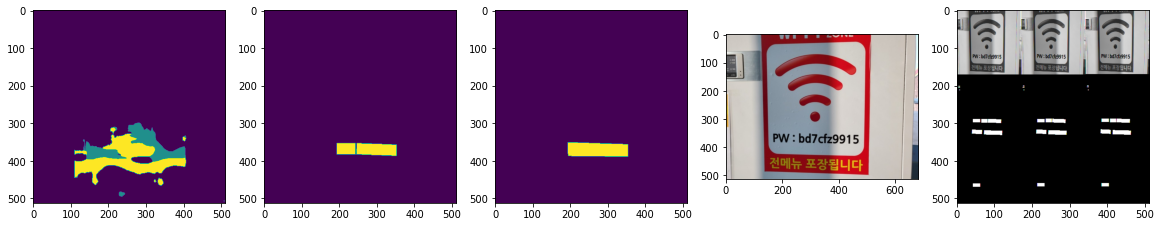

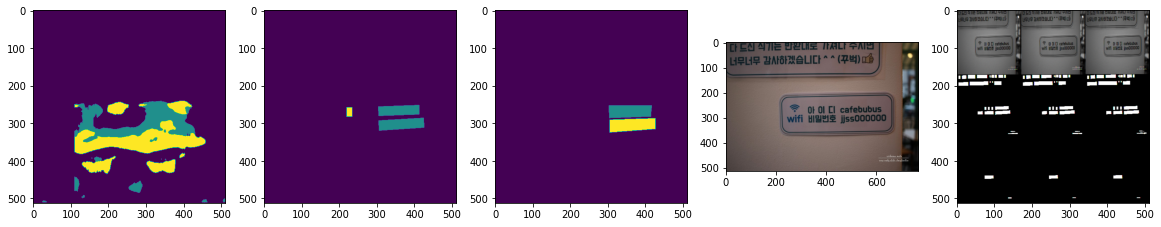

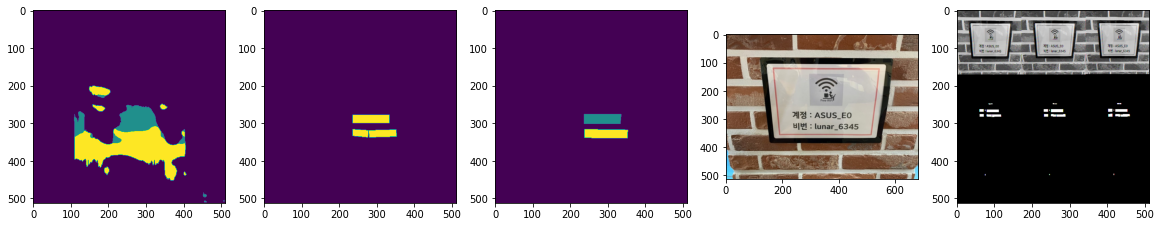

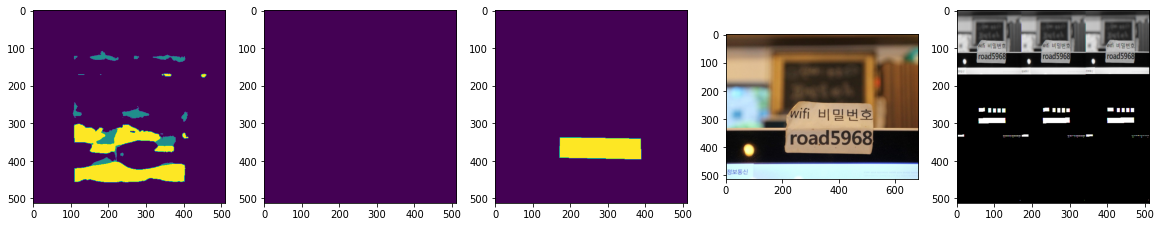

In [9]:
import matplotlib.pyplot as plt
import torchvision
import os
from PIL import Image
import numpy as np

for idx in range(4):
    out = torch.argmax(images[idx],dim=0)
    out2 = torch.argmax(new_images[idx],dim=0)
    image_meta = meta[idx][0]

    raw_image = Image.open(os.path.join(image_root,image_meta['file_name']))
    t = A.Compose([
        A.Resize(image_meta['height'],image_meta['width']),
        ToTensorV2()
    ])
    t2 = torchvision.transforms.Compose(
        [torchvision.transforms.ToPILImage()]
    )

    plt.figure(figsize=(20,20))

    plt.subplot(4,5,idx*5+1)
    plt.imshow(t2(out*0.3))

    plt.subplot(4,5,idx*5+2)
    plt.imshow(t2(out2*0.3))

    plt.subplot(4,5,idx*5+3)
    plt.imshow(t2(y[idx]*0.3))

    plt.subplot(4,5,idx*5+4)
    plt.imshow(raw_image)

    plt.subplot(4,5,idx*5+5)
    plt.imshow(t2(x[idx]))

plt.show()

In [10]:
x,y,_,_ = test_dataset[0]

In [12]:
x.shape

torch.Size([3, 512, 512])

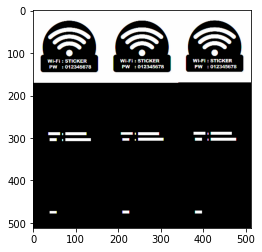

In [14]:
plt.imshow(t2(x))